In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from glob import glob
import cv2

In [2]:
train_waypoint = pd.read_csv('../input/indoor-location-train-waypoints/train_waypoints.csv')
hand_waypoint = pd.read_csv('../input/waypoint_by_hand.csv')

In [3]:
train_waypoint

,type_name,x,y,timestamp,site,floorNo,floor,path
0,TYPE_WAYPOINT,135.582200,51.289444,1573187328401,5da138274db8ce0c98bbd3d2,F3,2,5dc4f878171e610006b5d8ad
1,TYPE_WAYPOINT,142.696750,59.471970,1573187338226,5da138274db8ce0c98bbd3d2,F3,2,5dc4f878171e610006b5d8ad
2,TYPE_WAYPOINT,141.024860,64.242360,1573187425794,5da138274db8ce0c98bbd3d2,F3,2,5dc4f87921dceb00061144b7
3,TYPE_WAYPOINT,139.622480,58.041280,1573187432106,5da138274db8ce0c98bbd3d2,F3,2,5dc4f87921dceb00061144b7
4,TYPE_WAYPOINT,95.049780,27.868494,1573185829185,5da138274db8ce0c98bbd3d2,F3,2,5dc4f871171e610006b5d89f
...,...,...,...,...,...,...,...,...
75279,TYPE_WAYPOINT,34.642944,89.411290,1571975438239,5d27096c03f801723c31e5e0,F2,1,5db297bdec4254000601c0b8
75280,TYPE_WAYPOINT,89.285740,106.317330,1571984378712,5d27096c03f801723c31e5e0,F2,1,5db297e75741f4000680a7b6
75281,TYPE_WAYPOINT,89.512700,104.097420,1571984383629,5d27096c03f801723c31e5e0,F2,1,5db297e75741f4000680a7b6
75282,TYPE_WAYPOINT,63.716390,85.447940,1571808847255,5d27096c03f801723c31e5e0,F2,1,5daff020e62491000652b202


In [4]:
hand_waypoint

,site,floor,x,y
0,5a0546857ecc773753327266,0,73.5,124.0
1,5a0546857ecc773753327266,0,76.0,123.5
2,5a0546857ecc773753327266,0,71.5,116.0
3,5a0546857ecc773753327266,0,71.0,113.5
4,5a0546857ecc773753327266,1,106.0,77.5
...,...,...,...,...
406,5dc8cea7659e181adb076a3f,6,117.0,116.0
407,5dc8cea7659e181adb076a3f,6,123.0,106.5
408,5dc8cea7659e181adb076a3f,6,122.0,112.5
409,5dc8cea7659e181adb076a3f,6,129.0,114.5


In [10]:
# metaデータが存在するディレクトリ
DIR_META = '../input/indoor-location-navigation/metadata/'

# 画像の解像度(100とか200がいい感じかな。debugのときは一時的に10とかにすることもあります)
dpi = 100

In [11]:
def pil2cv(image):
    ''' PIL型 -> OpenCV型 '''
    new_image = np.array(image, dtype=np.uint8)
    if new_image.ndim == 2:  # モノクロ
        pass
    elif new_image.shape[2] == 3:  # カラー
        new_image = cv2.cvtColor(new_image, cv2.COLOR_RGB2BGR)
    elif new_image.shape[2] == 4:  # 透過
        new_image = cv2.cvtColor(new_image, cv2.COLOR_RGBA2BGRA)
    return new_image

In [12]:
import io

def get_metadata(site, floor):
    # geojsonファイルを使ってsiteの一番外枠を取得したい
    path_json = f'{DIR_META}{site}/{floor}/geojson_map.json'
    with open(path_json) as json_file:
        map = json.load(json_file)

    # 座標
    coordinates = map['features'][0]['geometry']['coordinates']
    x_list = []
    y_list = []
    for i in range(len(coordinates)):
        ndim = np.ndim(coordinates[i])
        if ndim ==2:
            x = np.array(coordinates[i])[:,0]
            y = np.array(coordinates[i])[:,1]
        elif ndim==3:
            x = np.array(coordinates[i])[0,:,0]
            y = np.array(coordinates[i])[0,:,1]
        else:
            print('dim error')
        x_list.append(x)
        y_list.append(y)
    x = np.concatenate(x_list)
    y = np.concatenate(y_list)
    xmax,xmin,ymax,ymin = max(x),min(x),max(y),min(y)
    x = x - x.min()
    y = y - y.min()
    
    # 実際のfloor画像に合体させる
    img_path = f'{DIR_META}{site}/{floor}/floor_image.png'
    img = cv2.imread(img_path, -1)  # alphaも読み取るため-1を与える (4次元)
    index = np.where(img[:, :, 3] == 0)  # alpha=0の箇所を抽出
    img[index] = [255, 255, 255, 255]  # 抽出した箇所を白塗り
    img = img[:,:,[0,1,2]]  # 4->3次元にする
    height = img.shape[1]
    width = img.shape[0]

    # スケールを揃える
    scale_x = height/(xmax - xmin)
    scale_y = width/(ymax - ymin)
    scale_x, scale_y
    x = x*scale_x
    y = y*scale_y
    xy = np.stack([x, y], axis=1)

    return img, xy

In [13]:
def create_auto_waypoint(site, floor):
    # 2つの画像をmergeして後の処理をしやすくする
    img, _xy = get_metadata(site, floor)   # w, h逆にする
    img = pil2cv(img)
    img_HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img_H, img_S, img_V = cv2.split(img_HSV)

    # json
    path_json = f'{DIR_META}{site}/{floor}/floor_info.json'
    with open(path_json) as json_file:
        json_data = json.load(json_file)
    w = json_data["map_info"]["width"]
    h = json_data["map_info"]["height"]

    # detect tulips
    thr = 1   # thrより大きいものを255(white)にする
    _thre, img_flowers = cv2.threshold(img_H, thr, 255, cv2.THRESH_BINARY)

    h_scale = h/img.shape[0]  # 1pxあたりのスケール
    w_scale = w/img.shape[1]  # 1pxあたりのスケール

    xy_list = []
    # find tulips
    contours, hierarchy = cv2.findContours(img_flowers, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    for i in range(0, len(contours)):
        if len(contours[i]) > 0:
            # remove small objects
            if cv2.contourArea(contours[i]) < 100:  # 500
                continue
            for j in range(len(contours[i])):

                if j % 20 == 0:  # hyperpara
                    # 座標抽出
                    x = contours[i][j,0,0]
                    y = contours[i][j,0,1]
                    x = x * w_scale  
                    y = h - (y * h_scale)
                    xy_list.append(np.array([x,y]))
    xy = np.stack(xy_list)

    # スケールを合わせる
    _xy[:,0] = _xy[:,0] * w_scale  
    _xy[:,1] = _xy[:,1] * h_scale 
    return img, xy, _xy, w, h

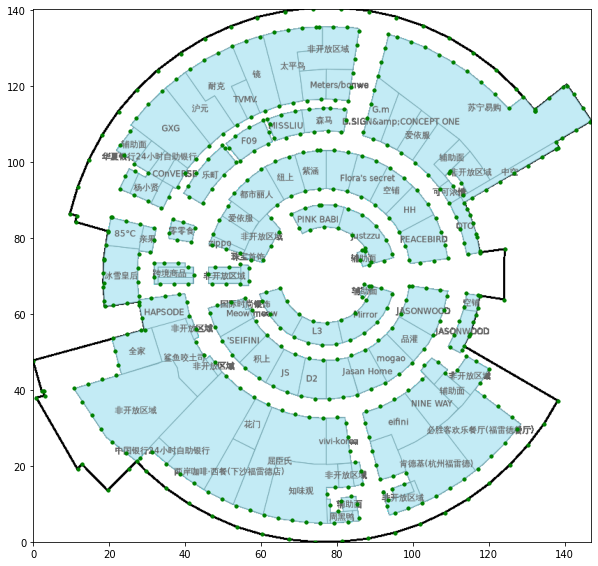

In [14]:
site = '5d2709d403f801723c32bd39'
floor = '1F'

img, xy, _xy, w, h = create_auto_waypoint(site, floor)
plt.figure(figsize=(10, 10))
plt.imshow(img, extent=(0, w, 0, h))  # スケールをextentで調整
plt.scatter(xy[:,0],xy[:,1], s=10, color='green')  # 内側
plt.scatter(_xy[:,0],_xy[:,1], s=10, color='green')  # 外側

In [15]:
from tqdm.notebook import tqdm
df_list = []
map_floor = {'B2': -2, 'B1': -1, 'F1': 0, 'F2': 1, 'F3': 2, 'F4': 3, 'F5': 4, 'F6': 5, 'F7': 6, 'F8': 7, 'F9': 8,
                '2B': -2, '1B': -1, '1F': 0, '2F': 1, '3F': 2, '4F': 3, '5F': 4, '6F': 5, '7F': 6, '8F': 7, '9F': 8}
for site in tqdm(sorted(train_waypoint['site'].unique())):
    print(site)
    floor_list = sorted(glob(f'{DIR_META}{site}/*'))
    floor_list = [text.split('/')[-1] for text in floor_list]
    for floor in floor_list:
        _, xy1, xy2, _, _ = create_auto_waypoint(site, floor)
        # df = pd.DataFrame(np.concatenate([xy1, xy2]), columns=['x', 'y'])
        df = pd.DataFrame(xy1, columns=['x', 'y'])

        df['site'] = site
        df['floor'] = map_floor[floor]
        df_list.append(df)
auto_waypoint = pd.concat(df_list).reset_index(drop=True)
auto_waypoint


  0%|          | 0/24 [00:00<?, ?it/s]

5a0546857ecc773753327266
5c3c44b80379370013e0fd2b
5d27075f03f801723c2e360f
5d27096c03f801723c31e5e0
5d27097f03f801723c320d97
5d27099f03f801723c32511d
5d2709a003f801723c3251bf
5d2709b303f801723c327472
5d2709bb03f801723c32852c
5d2709c303f801723c3299ee
5d2709d403f801723c32bd39
5d2709e003f801723c32d896
5da138274db8ce0c98bbd3d2
5da1382d4db8ce0c98bbe92e
5da138314db8ce0c98bbf3a0
5da138364db8ce0c98bc00f1
5da1383b4db8ce0c98bc11ab
5da138754db8ce0c98bca82f
5da138764db8ce0c98bcaa46
5da1389e4db8ce0c98bd0547
5da138b74db8ce0c98bd4774
5da958dd46f8266d0737457b
5dbc1d84c1eb61796cf7c010
5dc8cea7659e181adb076a3f


,x,y,site,floor
0,67.585359,6.423364,5a0546857ecc773753327266,-1
1,71.978407,4.056861,5a0546857ecc773753327266,-1
2,69.274993,6.423364,5a0546857ecc773753327266,-1
3,34.806460,6.761436,5a0546857ecc773753327266,-1
4,30.413411,4.056861,5a0546857ecc773753327266,-1
...,...,...,...,...
66254,207.302542,183.063156,5dc8cea7659e181adb076a3f,6
66255,200.539000,187.462085,5dc8cea7659e181adb076a3f,6
66256,193.775459,187.462085,5dc8cea7659e181adb076a3f,6
66257,187.011918,187.462085,5dc8cea7659e181adb076a3f,6


In [16]:
def visualize_map(train_waypoint, hand_waypoint, auto_waypoint, show=True, dpi=100):
    map_floor = {'B2': -2, 'B1': -1, 'F1': 0, 'F2': 1, 'F3': 2, 'F4': 3, 'F5': 4, 'F6': 5, 'F7': 6, 'F8': 7, 'F9': 8,
                 '2B': -2, '1B': -1, '1F': 0, '2F': 1, '3F': 2, '4F': 3, '5F': 4, '6F': 5, '7F': 6, '8F': 7, '9F': 8}
 
    site_list = train_waypoint['site'].unique()

    # site loop
    for site in sorted(site_list):
        floor_list = sorted(glob(f'{DIR_META}{site}/*'))
        floor_list = [text.split('/')[-1] for text in floor_list]
        
        # 画像の比を決めるために一度floor_info.jsonを取得
        path_json = f'{DIR_META}{site}/{floor_list[0]}/floor_info.json'
        with open(path_json) as json_file:
            json_data = json.load(json_file)
        _width_meter = json_data["map_info"]["width"]
        _height_meter = json_data["map_info"]["height"]
        s = max(_width_meter, _height_meter)

        t_site_wp = train_waypoint.loc[train_waypoint['site']==site, :].reset_index(drop=True)
        h_site_wp = hand_waypoint.loc[hand_waypoint['site']==site, :].reset_index(drop=True)
        a_site_wp = auto_waypoint.loc[auto_waypoint['site']==site, :].reset_index(drop=True)
        # figとaxesの用意
        n_floor = len(floor_list)
        n_row = int(np.ceil(n_floor / 3))
        w = round(5*3*_width_meter/s)
        h = round(5*n_row*_height_meter/s)
        fig, axs = plt.subplots(n_row, 3, figsize=(w, h), dpi=dpi)
        fig.suptitle(f'{site} (train:{len(t_site_wp)} hand:{len(h_site_wp)})', fontsize=15)
        fig.patch.set_facecolor('white')
        axs = axs.ravel()

        # floor loop
        for i_floor, floor in enumerate(floor_list):
            # json
            path_json = f'{DIR_META}{site}/{floor}/floor_info.json'
            with open(path_json) as json_file:
                json_data = json.load(json_file)
            width_meter = json_data["map_info"]["width"]
            height_meter = json_data["map_info"]["height"]

            t_wp = t_site_wp.loc[t_site_wp['floor']==map_floor[floor], :].reset_index(drop=True)
            h_wp = h_site_wp.loc[h_site_wp['floor']==map_floor[floor], :].reset_index(drop=True)
            a_wp = a_site_wp.loc[a_site_wp['floor']==map_floor[floor], :].reset_index(drop=True)

            # show image
            path_img = f'{DIR_META}{site}/{floor}/floor_image.png'
            im = Image.open(path_img)
            axs[i_floor].imshow(np.asarray(im), extent=(0, width_meter, 0, height_meter))
            axs[i_floor].set_title(f'{floor} (train:{len(t_wp)} hand:{len(h_wp)})', fontsize=10)

            # plot waypoint
            axs[i_floor].scatter(t_wp['x'], t_wp['y'], marker='o', color='red', s=1)
            axs[i_floor].scatter(h_wp['x'], h_wp['y'], marker='o', color='blue', s=1)
            axs[i_floor].scatter(a_wp['x'], a_wp['y'], marker='o', color='green', s=1)
        plt.tight_layout()
        # plt.savefig(f'./waypoint/{site}.png')
        plt.show()

In [17]:
def visualize_onemap(train_waypoint, hand_waypoint, auto_waypoint, site, floor, dir_meta=DIR_META, show=True, dpi=100):
    map_floor = {'B2': -2, 'B1': -1, 'F1': 0, 'F2': 1, 'F3': 2, 'F4': 3, 'F5': 4, 'F6': 5, 'F7': 6, 'F8': 7, 'F9': 8,
                 '2B': -2, '1B': -1, '1F': 0, '2F': 1, '3F': 2, '4F': 3, '5F': 4, '6F': 5, '7F': 6, '8F': 7, '9F': 8}
    path_json = f'{dir_meta}{site}/{floor}/floor_info.json'
    with open(path_json) as json_file:
        json_data = json.load(json_file)
    width_meter = json_data["map_info"]["width"]
    height_meter = json_data["map_info"]["height"]

    # show image
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111)
    path_img = f'{dir_meta}{site}/{floor}/floor_image.png'
    im = Image.open(path_img)
    ax.imshow(np.asarray(im), extent=(0, width_meter, 0, height_meter))
    ax.set_title(floor, fontsize=10)

    # train&hand waypoint
    t_wp = train_waypoint.loc[(train_waypoint['site']==site)&(train_waypoint['floor']==map_floor[floor]), :].reset_index(drop=True)
    h_wp = hand_waypoint.loc[(hand_waypoint['site']==site)&(hand_waypoint['floor']==map_floor[floor]), :].reset_index(drop=True)
    ax.scatter(t_wp['x'], t_wp['y'], marker='o', color='red', s=5, label='train')
    ax.scatter(h_wp['x'], h_wp['y'], marker='o', color='blue', s=5, label='hand')

    # auto waypoint
    a_wp = auto_waypoint.loc[(auto_waypoint['site']==site)&(auto_waypoint['floor']==map_floor[floor]), :].reset_index(drop=True)
    ax.scatter(a_wp['x'], a_wp['y'], marker='o', color='green', s=10, label='auto')
    plt.legend()
    plt.tight_layout()
    # plt.savefig('auto_waypoint_sample.png')
    plt.show()

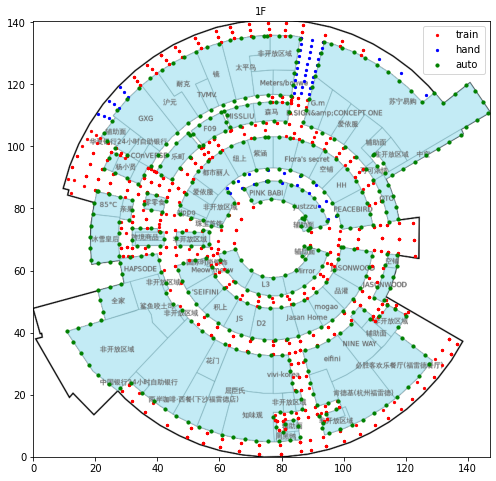

In [18]:
site = '5d2709d403f801723c32bd39'
floor = '1F'
visualize_onemap(train_waypoint, hand_waypoint, auto_waypoint,site,floor)

In [19]:
auto_waypoint.to_csv('../input/auto_waypoint_v1.csv', index=False)

In [1]:
# visualize submission
#visualize_map(train_waypoint, hand_waypoint, auto_waypoint, dpi=dpi)

In [25]:
auto_waypoint

,x,y,site,floor
0,114.130012,48.912389,5a0546857ecc773753327266,-1
1,111.557032,45.234766,5a0546857ecc773753327266,-1
2,108.432700,44.499241,5a0546857ecc773753327266,-1
3,106.594858,47.441340,5a0546857ecc773753327266,-1
4,103.102957,46.521934,5a0546857ecc773753327266,-1
...,...,...,...,...
59209,85.275886,130.923387,5dc8cea7659e181adb076a3f,6
59210,85.827239,134.601010,5dc8cea7659e181adb076a3f,6
59211,82.702907,135.520416,5dc8cea7659e181adb076a3f,6
59212,79.027222,135.704297,5dc8cea7659e181adb076a3f,6
